# Metrics Evaluator

### Introduction

To make sure that the splits don't make me choose a wrong model (since the difference of the finalist models is very little), I will run all of them many times to get a consistent metric from them, averaging its scores and stds.

Beware that for each model (1 & 2) the average time that it takes to train 300 models is 50 minutes, so either trust my results or be patient.

In [7]:
# Load the necessary modules
# Relative paths (make sure you are in src)
import os, sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Data management libraries 
import numpy as np 
import pandas as pd 

# My code
from data_processing import get_path
from Models.RandomForest import Random_Forest_ensemble
from Models.BaggingEnsemble import Bagging_Ensemble
from Models.LinearRegressor import LinearRegressor
from Models.LogisticRegressor import LogisticRegressor
from Models.LinearRegressionVariants import LR_Relations, LR_ensemble
from Models.SVR import SVR_manual
from utils import evaluate_regression_metrics
from data_processing import standarize_numerical_variables

# Machine learning libraries 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,StackingRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LassoCV
from sklearn.svm import SVR
from sklearn.utils import shuffle
import shap

# Parameters
import configparser
config = configparser.ConfigParser()
config.read('../configuration.ini')

c:\Users\luciaa_herraiz\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['../configuration.ini']

In [50]:
# Import data from relative path for train
file = get_path('created_files','train',parent_dir)
data = pd.read_csv(file,sep = ',')
X_train_p = data.drop(columns=['T3']).reset_index(drop=True)
y_train_p = data['T3'].reset_index(drop=True)

# Do the train/ test split and standarize AFTER so there is no data leakage
X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_train_p,y_train_p,test_size=0.2)
X_train, X_test, y_train,y_test,scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd,1)


### Model 1: Final Models

I will run this code twice, so I will test 600 models. In my paper, I will average as well both runs.

Models to try out in the Metrics Evaluator

In [6]:
base_models = [
    ('gbr', GradientBoostingRegressor(n_estimators=50,max_features=0.8,subsample=0.9,random_state=42)),
    ('RF', RandomForestRegressor(random_state=42,n_estimators=100,max_features=0.8) ),
    ('bag', BaggingRegressor(random_state=42,n_estimators=100))
]
stack = StackingRegressor(estimators=base_models, final_estimator=LassoCV(), cv=5, passthrough=True)
rf = RandomForestRegressor(random_state=0,n_estimators=100,max_features=0.8) 
svr  = SVR(C=1, gamma='scale',kernel='linear')
gb = GradientBoostingRegressor(n_estimators=50,max_features=0.8,subsample=0.9,random_state=0)

models = [LinearRegression(),stack,BaggingRegressor(random_state=0,n_estimators=100), rf,svr,gb]
names = ['LinReg','Stack','Bagging','Random Forest','SVR','Boosting']


### Metrics Evaluator Code

In [7]:
final_scores = []

for model in models:
    scores = []
    stds = []
    scores_train = []
    MAE = []
    MSE = []
    for _ in range(300):
        X_shuffled, y_shuffled = shuffle(X_train_p, y_train_p, random_state=None)
        X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
        X_train, X_test, y_train, y_test, scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd, 1)

        model.fit(X_train,y_train_unstd)
        predictions = model.predict(X_test)
        predictions_train = model.predict(X_train)

        score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,predictions,predictions_train)
        scores.append(score['R² Score Test:'])
        scores_train.append(score['R² Score Train:'])
        MAE.append(score['Mean Absolute Error:'])
        MSE.append(score['Mean Squared Error:'])

    final_scores.append([np.mean(scores),np.std(scores),np.mean(MAE),np.mean(MSE),np.mean(scores_train)])

results_df = pd.DataFrame(final_scores, columns=['R² Mean Test', 'R² Std Test', 'Mean Absolute Error', 'Mean Squared Error', 'R² Mean Train'], index=names)


In [8]:
scores = []
scores_train = []
MAE = []
MSE = []
for _ in range(300):
    X_shuffled, y_shuffled = shuffle(X_train_p, y_train_p, random_state=None)
    X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
    X_train, X_test, y_train, y_test, scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd, 1)

    LR_Rel = LR_Relations()
    LR_Rel.fit(X_train,X_test,y_train_unstd)
    predictions,score = LR_Rel.predict(y_test_unstd,y_train_unstd)
    scores.append(score['R² Score Test:'])
    scores_train.append(score['R² Score Train:'])
    MAE.append(score['Mean Absolute Error:'])
    MSE.append(score['Mean Squared Error:'])

final_score = [np.mean(scores),np.std(scores),np.mean(MAE),np.mean(MSE),np.mean(scores_train)]
results_df.loc['LR_Relations'] = final_score

In [9]:
scores = []
scores_train = []
MAE = []
MSE = []
for _ in range(300):
    X_shuffled, y_shuffled = shuffle(X_train_p, y_train_p, random_state=None)
    X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
    X_train, X_test, y_train, y_test, scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd, 1)

    LR_E = LR_ensemble()
    LR_E.fit(X_train,X_test,y_train_unstd)
    predictions = LR_E.predict()
    score = LR_E.score_complete(y_test_unstd,y_train_unstd)
    scores.append(score['R² Score Test:'])
    scores_train.append(score['R² Score Train:'])
    MAE.append(score['Mean Absolute Error:'])
    MSE.append(score['Mean Squared Error:'])

final_score = [np.mean(scores),np.std(scores),np.mean(MAE),np.mean(MSE),np.mean(scores_train)]
results_df.loc['LR_Ensemble'] = final_score

In [10]:
print(results_df)

               R² Mean Test  R² Std Test  Mean Absolute Error  \
LinReg             0.829300     0.037707             0.999028   
Stack              0.866407     0.030573             0.889439   
Bagging            0.854287     0.038104             0.919530   
Random Forest      0.853219     0.034945             0.920570   
SVR                0.833179     0.037196             0.910729   
Boosting           0.867096     0.032469             0.896823   
LR_Relations       0.832364     0.034471             0.997036   
LR_Ensemble        0.828645     0.033886             1.004951   

               Mean Squared Error  R² Mean Train  
LinReg                   2.683789       0.853258  
Stack                    2.111856       0.936517  
Bagging                  2.287698       0.979346  
Random Forest            2.317301       0.980165  
SVR                      2.645778       0.839969  
Boosting                 2.126995       0.925864  
LR_Relations             2.627998       0.854737  
LR_Ens

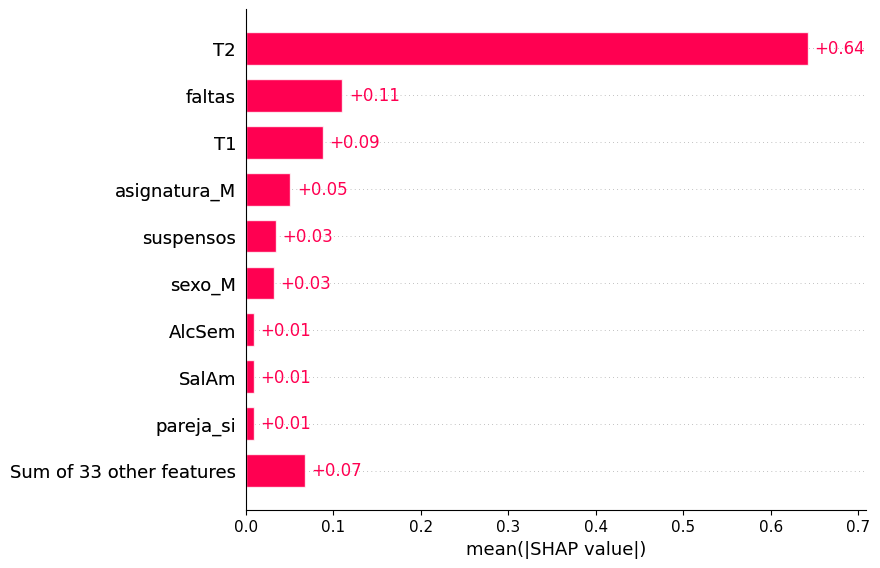

C:\Users\luciaa_herraiz\AppData\Local\Temp\ipykernel_32628\313378026.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_float[:100], feature_names=X_train.columns)


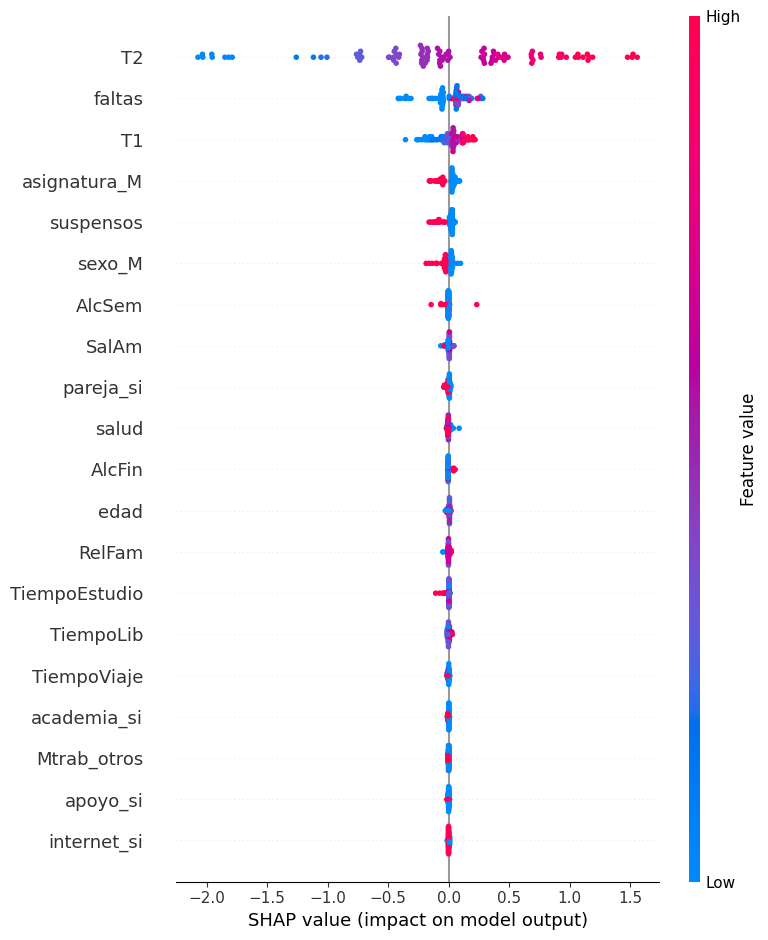

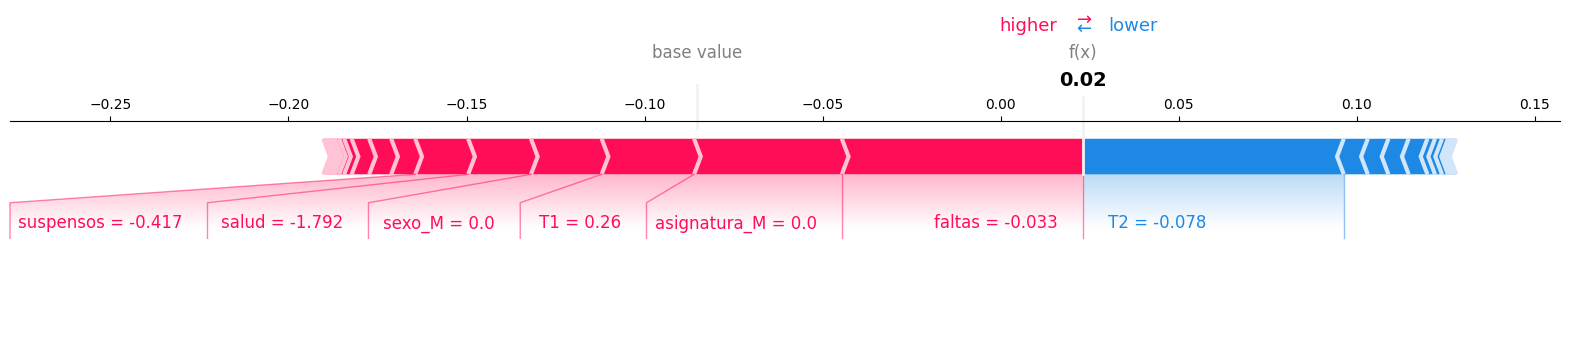

In [ ]:
X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

model = GradientBoostingRegressor(n_estimators=50,max_features=0.8,subsample=0.9,random_state=42)
model.fit(X_train, y_train)

explainer = shap.Explainer(model, X_train_float)
shap_values = explainer(X_test_float[:100])  
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test_float[:100], feature_names=X_train.columns) 
rounded_features = X_test_float.iloc[0, :].round(3) # The plot without this was messy with all the decimals
shap.plots.force(shap_values[0], matplotlib=True, features=rounded_features)

### Model 2: Final Models
Models to try out in the Metrics Evaluator.

It is curious to see that the n_estimators that I got from cross-validation is for the 3 ensemble models, exactly twice the number.

In [60]:
# Import data from relative path for train
file = get_path('created_files','train',parent_dir)
data = pd.read_csv(file,sep = ',')
X_train_p = data.drop(columns=['T3','T2','T1']).reset_index(drop=True)
y_train_p = data['T3'].reset_index(drop=True)

# Do the train/ test split and standarize AFTER so there is no data leakage
X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_train_p,y_train_p,test_size=0.2)
X_train, X_test, y_train,y_test,scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd,2)

In [3]:
base_models = [
    ('gbr', GradientBoostingRegressor(n_estimators=100,max_features=0.8,subsample=0.5,random_state=42)),
    ('RF', RandomForestRegressor(random_state=42,n_estimators=200,max_features=0.8) ),
    ('bag', BaggingRegressor(random_state=42,n_estimators=200))]

stack = StackingRegressor(estimators=base_models, final_estimator=LassoCV(), cv=5, passthrough=True)
rf = RandomForestRegressor(random_state=0,n_estimators=200,max_features=0.8) 
svr  = SVR(C=10, gamma='scale',kernel='rbf')
gb = GradientBoostingRegressor(n_estimators=100,max_features=0.8,subsample=0.5,random_state=0)
bg = BaggingRegressor(random_state=0,n_estimators=200)

models_m2 = [LinearRegression(),stack,bg, rf,svr,gb]
names_m2 = ['LinReg','Stack','Bagging','Random Forest','SVR','Boosting']

### Metrics Evaluator Code

In [4]:
final_scores_m2 = []

for model in models_m2:
    scores = []
    stds = []
    scores_train = []
    MAE = []
    MSE = []
    for _ in range(300):
        X_shuffled, y_shuffled = shuffle(X_train_p, y_train_p, random_state=None)
        X_train, X_test, y_train_unstd, y_test_unstd = train_test_split(X_shuffled, y_shuffled, test_size=0.2)
        X_train, X_test, y_train, y_test, scaler_y = standarize_numerical_variables(X_train, X_test, y_train_unstd, y_test_unstd, 2)

        model.fit(X_train,y_train_unstd)
        predictions = model.predict(X_test)
        predictions_train = model.predict(X_train)

        score = evaluate_regression_metrics(y_test_unstd,y_train_unstd,predictions,predictions_train)
        scores.append(score['R² Score Test:'])
        scores_train.append(score['R² Score Train:'])
        MAE.append(score['Mean Absolute Error:'])
        MSE.append(score['Mean Squared Error:'])

    final_scores_m2.append([np.mean(scores),np.std(scores),np.mean(MAE),np.mean(MSE),np.mean(scores_train)])

results_df_m2 = pd.DataFrame(final_scores_m2, columns=['R² Mean Test', 'R² Std Test', 'Mean Absolute Error', 'Mean Squared Error', 'R² Mean Train'], index=names_m2)

In [5]:
print(results_df_m2)

               R² Mean Test  R² Std Test  Mean Absolute Error  \
LinReg             0.197620     0.062700             2.582667   
Stack              0.321687     0.068990             2.400883   
Bagging            0.292216     0.076781             2.404920   
Random Forest      0.310166     0.079903             2.385468   
SVR                0.276977     0.062823             2.416441   
Boosting           0.299645     0.081889             2.474754   

               Mean Squared Error  R² Mean Train  
LinReg                  12.631375       0.302711  
Stack                   10.722541       0.783423  
Bagging                 11.117651       0.905291  
Random Forest           10.919621       0.906048  
SVR                     11.422180       0.732041  
Boosting                11.016038       0.682736  


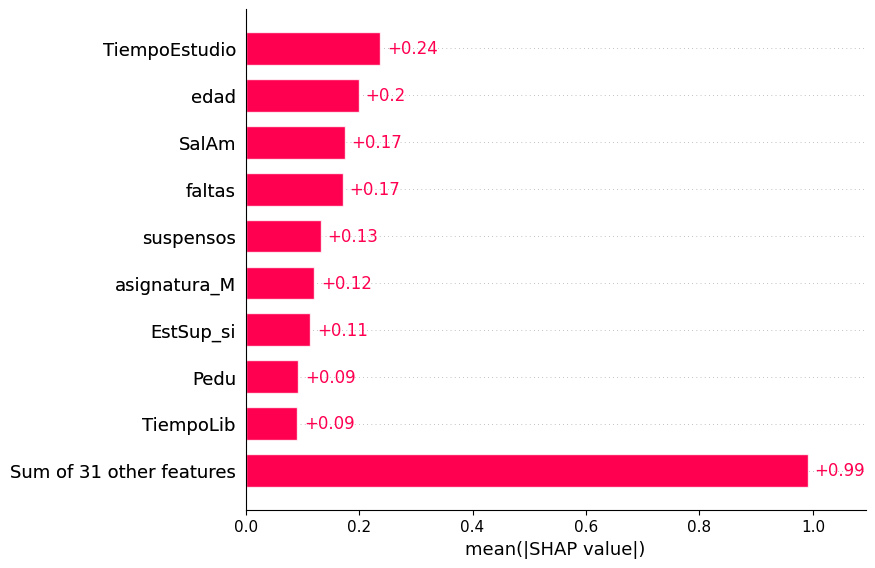

C:\Users\luciaa_herraiz\AppData\Local\Temp\ipykernel_32628\484030076.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_float[:100], feature_names=X_train.columns)


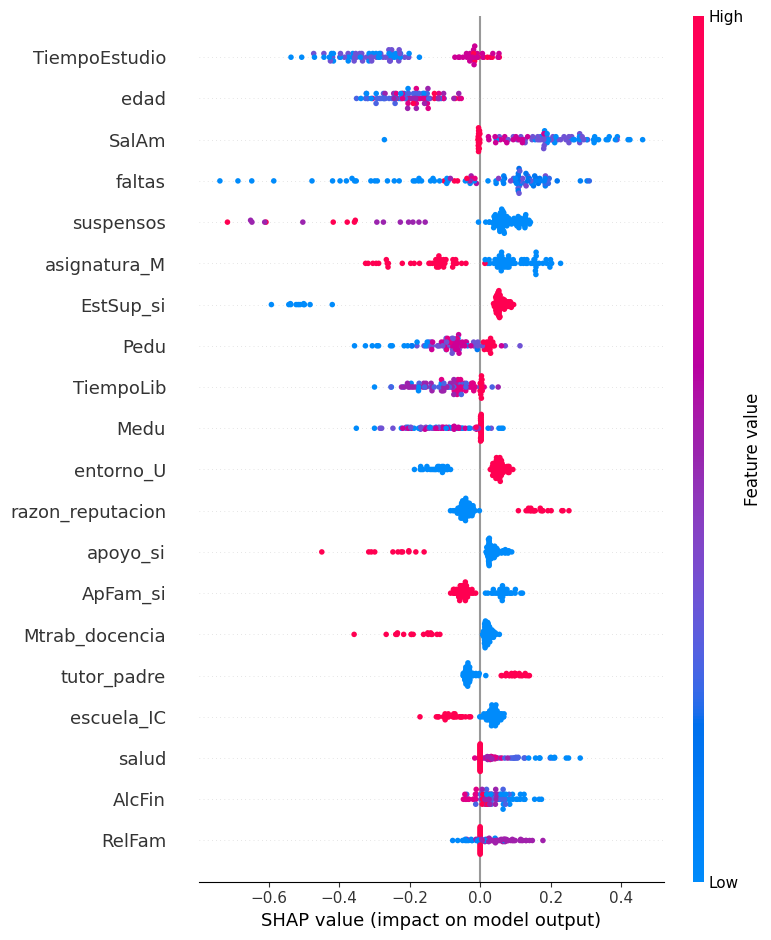

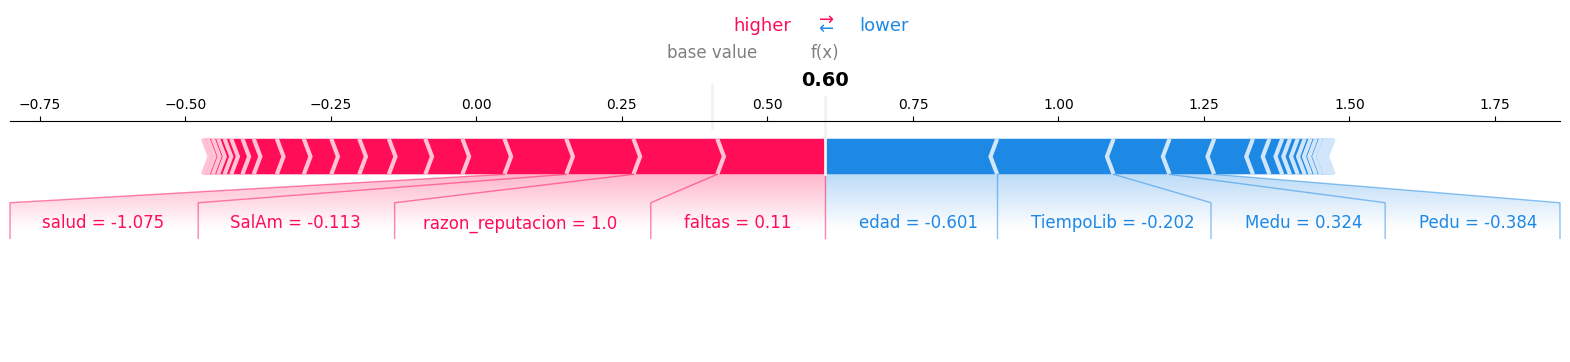

In [61]:
X_train_float = X_train_p.astype(float)
X_test_float = X_test.astype(float)

model = GradientBoostingRegressor(n_estimators=100,max_features=0.8,subsample=0.5,random_state=42)
model.fit(X_train, y_train)

explainer = shap.Explainer(model, X_train_float)
shap_values = explainer(X_test_float[:100])  
shap.plots.bar(shap_values)
shap.summary_plot(shap_values, X_test_float[:100], feature_names=X_train.columns) 
rounded_features = X_test_float.iloc[0, :].round(3) # The plot without this was messy with all the decimals
shap.plots.force(shap_values[0], matplotlib=True, features=rounded_features)